# Lab 4: Bag of Visual Words (BoVW) for Image Classification

## Objective
Implement the Bag of Visual Words technique for image classification using:
- UC Merced Land Use Dataset
- SIFT features for local descriptor extraction
- K-means clustering for visual vocabulary creation
- SVM classifier for classification

## Pipeline Steps:
1. Data Loading and Preprocessing
2. Dataset Splitting (80% train, 20% test)
3. SIFT Feature Extraction
4. Building Visual Vocabulary (K-means clustering)
5. Quantization (assign descriptors to visual words)
6. Histogram Representation
7. Normalization (L1 or L2)
8. Classifier Training (SVM)
9. Prediction Generation
10. Performance Evaluation

In [ ]:
# Import required libraries
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


## Step 1: Data Loading and Preprocessing

In [4]:
def list_images_and_labels(dataset_root):
    """
    Load all images and their corresponding labels from the dataset directory.
    
    Args:
        dataset_root: Path to the dataset root directory
        
    Returns:
        images: List of image file paths
        labels: List of corresponding class labels
        classes: List of unique class names
    """
    images = []
    labels = []
    
    # Get all class directories (sorted for consistency)
    classes = sorted([d for d in os.listdir(dataset_root) 
                     if os.path.isdir(os.path.join(dataset_root, d))])
    
    # Iterate through each class directory
    for cls in classes:
        cls_dir = os.path.join(dataset_root, cls)
        for fname in os.listdir(cls_dir):
            # Load .tif files (UC Merced dataset format)
            if fname.lower().endswith(".tif"):
                images.append(os.path.join(cls_dir, fname))
                labels.append(cls)
    
    return images, labels, classes

# Load dataset
DATASET_PATH = "./Images"  # Update this path if needed
images, labels, class_names = list_images_and_labels(DATASET_PATH)

if not images:
    raise RuntimeError("No images found. Check dataset path and structure.")

print(f"Dataset loaded successfully!")
print(f"Total classes: {len(class_names)}")
print(f"Total images: {len(images)}")
print(f"Classes: {class_names}")

Dataset loaded successfully!
Total classes: 21
Total images: 2100
Classes: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


## Step 2: Dataset Splitting (80% Train, 20% Test)

In [5]:
# Split dataset into training (80%) and testing (20%) sets
# Use stratify to maintain class balance
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    images, 
    labels, 
    test_size=0.2,  # 20% for testing
    stratify=labels,  # Maintain class distribution
    random_state=42  # For reproducibility
)

print(f"Training set: {len(X_train_paths)} images")
print(f"Testing set: {len(X_test_paths)} images")
print(f"Split ratio: {len(X_train_paths)/len(images)*100:.1f}% train, {len(X_test_paths)/len(images)*100:.1f}% test")

Training set: 1680 images
Testing set: 420 images
Split ratio: 80.0% train, 20.0% test


## Step 3: SIFT Feature Extraction

In [6]:
def read_and_preprocess(path, size=(256, 256)):
    """
    Read and preprocess an image.
    
    Args:
        path: Image file path
        size: Target size for resizing
        
    Returns:
        Preprocessed grayscale image
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Unable to read image: {path}")
    # Resize for consistency
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return img

# Initialize SIFT detector
sift = cv2.SIFT_create()

print("Extracting SIFT descriptors from training images...")
print("This may take a few minutes...")

train_descriptors_list = []  # Store descriptors for each image
all_train_descriptors = []   # Store all descriptors for K-means

# Extract SIFT features from training images
for path in tqdm(X_train_paths, desc="SIFT extraction (train)"):
    img = read_and_preprocess(path)
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    # Handle images with no keypoints
    if descriptors is None:
        descriptors = np.zeros((1, 128), dtype=np.float32)
    
    train_descriptors_list.append(descriptors)
    all_train_descriptors.append(descriptors)

# Stack all descriptors for K-means clustering
all_train_descriptors = np.vstack(all_train_descriptors).astype(np.float32)

print(f"\nSIFT extraction completed!")
print(f"Total descriptors extracted: {all_train_descriptors.shape[0]}")
print(f"Descriptor dimension: {all_train_descriptors.shape[1]}")

Extracting SIFT descriptors from training images...
This may take a few minutes...


SIFT extraction (train): 100%|██████████| 1680/1680 [00:46<00:00, 36.30it/s]



SIFT extraction completed!
Total descriptors extracted: 1172219
Descriptor dimension: 128


## Step 4: Building Visual Vocabulary with K-means Clustering

In [7]:
# Build visual vocabulary using K-means clustering
# Each cluster center represents a "visual word"

K = 100  # Number of visual words (cluster centers)

print(f"\nBuilding visual vocabulary with K={K} visual words...")
print("Running K-means clustering...")

# Use MiniBatchKMeans for faster processing with large datasets
kmeans = MiniBatchKMeans(
    n_clusters=K,
    batch_size=1000,
    random_state=42,
    verbose=1
)

# Fit K-means on all training descriptors
kmeans.fit(all_train_descriptors)

# Visual vocabulary = cluster centers
visual_vocabulary = kmeans.cluster_centers_

print(f"\nVisual vocabulary created!")
print(f"Vocabulary shape: {visual_vocabulary.shape}")
print(f"Each visual word is a {visual_vocabulary.shape[1]}-dimensional vector")


Building visual vocabulary with K=100 visual words...
Running K-means clustering...
Init 1/1 with method k-means++
Inertia for init 1/1: 379642272.0
Minibatch step 1/117221: mean batch inertia: 126196.832
Minibatch step 2/117221: mean batch inertia: 92220.072, ewa inertia: 92220.072
Minibatch step 3/117221: mean batch inertia: 89515.024, ewa inertia: 92215.45674347818
Minibatch step 4/117221: mean batch inertia: 87249.832, ewa inertia: 92206.98457145676
Minibatch step 5/117221: mean batch inertia: 87189.704, ewa inertia: 92198.42426610205
Minibatch step 6/117221: mean batch inertia: 87256.848, ewa inertia: 92189.99312473592
Minibatch step 7/117221: mean batch inertia: 86112.56, ewa inertia: 92179.62402486603
Minibatch step 8/117221: mean batch inertia: 87001.024, ewa inertia: 92170.78848200741
Minibatch step 9/117221: mean batch inertia: 85011.632, ewa inertia: 92158.57378428514
Minibatch step 10/117221: mean batch inertia: 84039.992, ewa inertia: 92144.72214929464
Minibatch step 11/1

## Step 5: Quantization and Histogram Representation

Quantization: Assign each local descriptor to its nearest visual word.  
Histogram: Count occurrences of each visual word in the image.

In [8]:
def create_histogram(descriptors, kmeans_model, k):
    """
    Create histogram of visual words for an image.
    
    Args:
        descriptors: SIFT descriptors of the image
        kmeans_model: Trained K-means model
        k: Number of clusters (visual words)
        
    Returns:
        Histogram of visual word occurrences
    """
    # Quantization: Assign each descriptor to nearest cluster center
    visual_words = kmeans_model.predict(descriptors)
    
    # Create histogram: Count occurrences of each visual word
    histogram = np.zeros(k)
    for word in visual_words:
        histogram[word] += 1
    
    return histogram

print("Creating histograms for training images...")

# Create histograms for all training images
X_train_histograms = []
for descriptors in tqdm(train_descriptors_list, desc="Creating histograms (train)"):
    hist = create_histogram(descriptors, kmeans, K)
    X_train_histograms.append(hist)

X_train_histograms = np.array(X_train_histograms)

print(f"\nHistograms created!")
print(f"Training histogram matrix shape: {X_train_histograms.shape}")
print(f"Each image represented as {K}-dimensional histogram")

Creating histograms for training images...


Creating histograms (train): 100%|██████████| 1680/1680 [00:02<00:00, 645.47it/s] 


Histograms created!
Training histogram matrix shape: (1680, 100)
Each image represented as 100-dimensional histogram


## Step 6: Normalization

Normalize histograms to account for variations in the number of features per image.

- **L1 Normalization**: Sum of histogram values = 1 (frequency distribution)
- **L2 Normalization**: Sum of squares = 1 (scale invariance)

In [9]:
# Choose normalization method: 'l1' or 'l2'
NORMALIZATION = 'l2'  # Change to 'l1' if desired

print(f"Applying {NORMALIZATION.upper()} normalization...")

# Normalize histograms
if NORMALIZATION == 'l1':
    # L1: Sum of values = 1
    X_train_normalized = normalize(X_train_histograms, norm='l1', axis=1)
    print("L1 normalization: Each histogram sums to 1")
elif NORMALIZATION == 'l2':
    # L2: Sum of squares = 1
    X_train_normalized = normalize(X_train_histograms, norm='l2', axis=1)
    print("L2 normalization: Euclidean norm = 1")

print(f"Normalized training data shape: {X_train_normalized.shape}")

# Verify normalization
if NORMALIZATION == 'l1':
    print(f"Sample L1 norm (should be ~1.0): {np.sum(X_train_normalized[0]):.6f}")
elif NORMALIZATION == 'l2':
    print(f"Sample L2 norm (should be ~1.0): {np.linalg.norm(X_train_normalized[0]):.6f}")

Applying L2 normalization...
L2 normalization: Euclidean norm = 1
Normalized training data shape: (1680, 100)
Sample L2 norm (should be ~1.0): 1.000000


## Step 7: Classifier Training (Support Vector Machine)

In [10]:
print("\nTraining SVM classifier...")
print("This may take several minutes...")

# Train Support Vector Machine classifier
svm_classifier = SVC(
    kernel='rbf',      # Radial Basis Function kernel
    C=10,              # Regularization parameter
    gamma='scale',     # Kernel coefficient
    random_state=42,
    verbose=True
)

# Train on normalized histograms and corresponding labels
svm_classifier.fit(X_train_normalized, y_train)

print("\nSVM training completed!")


Training SVM classifier...
This may take several minutes...
[LibSVM]*
optimization finished, #iter = 118
obj = -14.259050, rho = -0.547302
nSV = 55, nBSV = 0
*
optimization finished, #iter = 135
obj = -16.617144, rho = -0.403371
nSV = 64, nBSV = 0
*
optimization finished, #iter = 155
obj = -43.374493, rho = -0.104953
nSV = 74, nBSV = 1
*
optimization finished, #iter = 116
obj = -9.040285, rho = -0.668608
nSV = 52, nBSV = 0
*
optimization finished, #iter = 126
obj = -15.562292, rho = -0.653928
nSV = 48, nBSV = 0
*
optimization finished, #iter = 114
obj = -8.432842, rho = -0.706088
nSV = 54, nBSV = 0
*
optimization finished, #iter = 96
obj = -9.285984, rho = -0.746117
nSV = 42, nBSV = 0
*.*
optimization finished, #iter = 221
obj = -34.598742, rho = -0.621570
nSV = 64, nBSV = 1
*
optimization finished, #iter = 157
obj = -15.910495, rho = -0.327627
nSV = 71, nBSV = 0
*
optimization finished, #iter = 104
obj = -8.260393, rho = -0.712704
nSV = 50, nBSV = 0
*
optimization finished, #iter = 1

## Step 8: Generate Predictions on Test Set

In [11]:
print("Processing test images...")

# Extract SIFT features from test images
test_descriptors_list = []

for path in tqdm(X_test_paths, desc="SIFT extraction (test)"):
    img = read_and_preprocess(path)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    if descriptors is None:
        descriptors = np.zeros((1, 128), dtype=np.float32)
    
    test_descriptors_list.append(descriptors)

print("\nCreating histograms for test images...")

# Create and normalize histograms for test images
X_test_histograms = []
for descriptors in tqdm(test_descriptors_list, desc="Creating histograms (test)"):
    hist = create_histogram(descriptors, kmeans, K)
    X_test_histograms.append(hist)

X_test_histograms = np.array(X_test_histograms)

# Apply same normalization as training data
X_test_normalized = normalize(X_test_histograms, norm=NORMALIZATION, axis=1)

print(f"\nTest data prepared!")
print(f"Test histogram matrix shape: {X_test_normalized.shape}")

# Generate predictions
print("\nGenerating predictions...")
y_pred = svm_classifier.predict(X_test_normalized)
print("Predictions completed!")

Processing test images...


SIFT extraction (test): 100%|██████████| 420/420 [00:18<00:00, 22.31it/s]



Creating histograms for test images...


Creating histograms (test): 100%|██████████| 420/420 [00:01<00:00, 354.31it/s]



Test data prepared!
Test histogram matrix shape: (420, 100)

Generating predictions...
Predictions completed!


## Step 9: Performance Evaluation

In [12]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print("\n" + "="*60)
print("PERFORMANCE EVALUATION")
print("="*60)
print(f"\nClassification Accuracy: {accuracy * 100:.2f}%")
print(f"Correctly classified: {int(accuracy * len(y_test))}/{len(y_test)} images")
print("\n" + "="*60)

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


PERFORMANCE EVALUATION

Classification Accuracy: 67.62%
Correctly classified: 284/420 images


Detailed Classification Report:
                   precision    recall  f1-score   support

     agricultural       0.84      0.80      0.82        20
         airplane       0.75      0.75      0.75        20
  baseballdiamond       0.45      0.45      0.45        20
            beach       0.84      0.80      0.82        20
        buildings       0.50      0.75      0.60        20
        chaparral       1.00      0.95      0.97        20
 denseresidential       0.60      0.60      0.60        20
           forest       0.68      0.95      0.79        20
          freeway       0.61      0.55      0.58        20
       golfcourse       0.78      0.70      0.74        20
           harbor       1.00      0.85      0.92        20
     intersection       0.55      0.60      0.57        20
mediumresidential       0.47      0.40      0.43        20
   mobilehomepark       0.72      0.65      0

## Step 10: Confusion Matrix Visualization

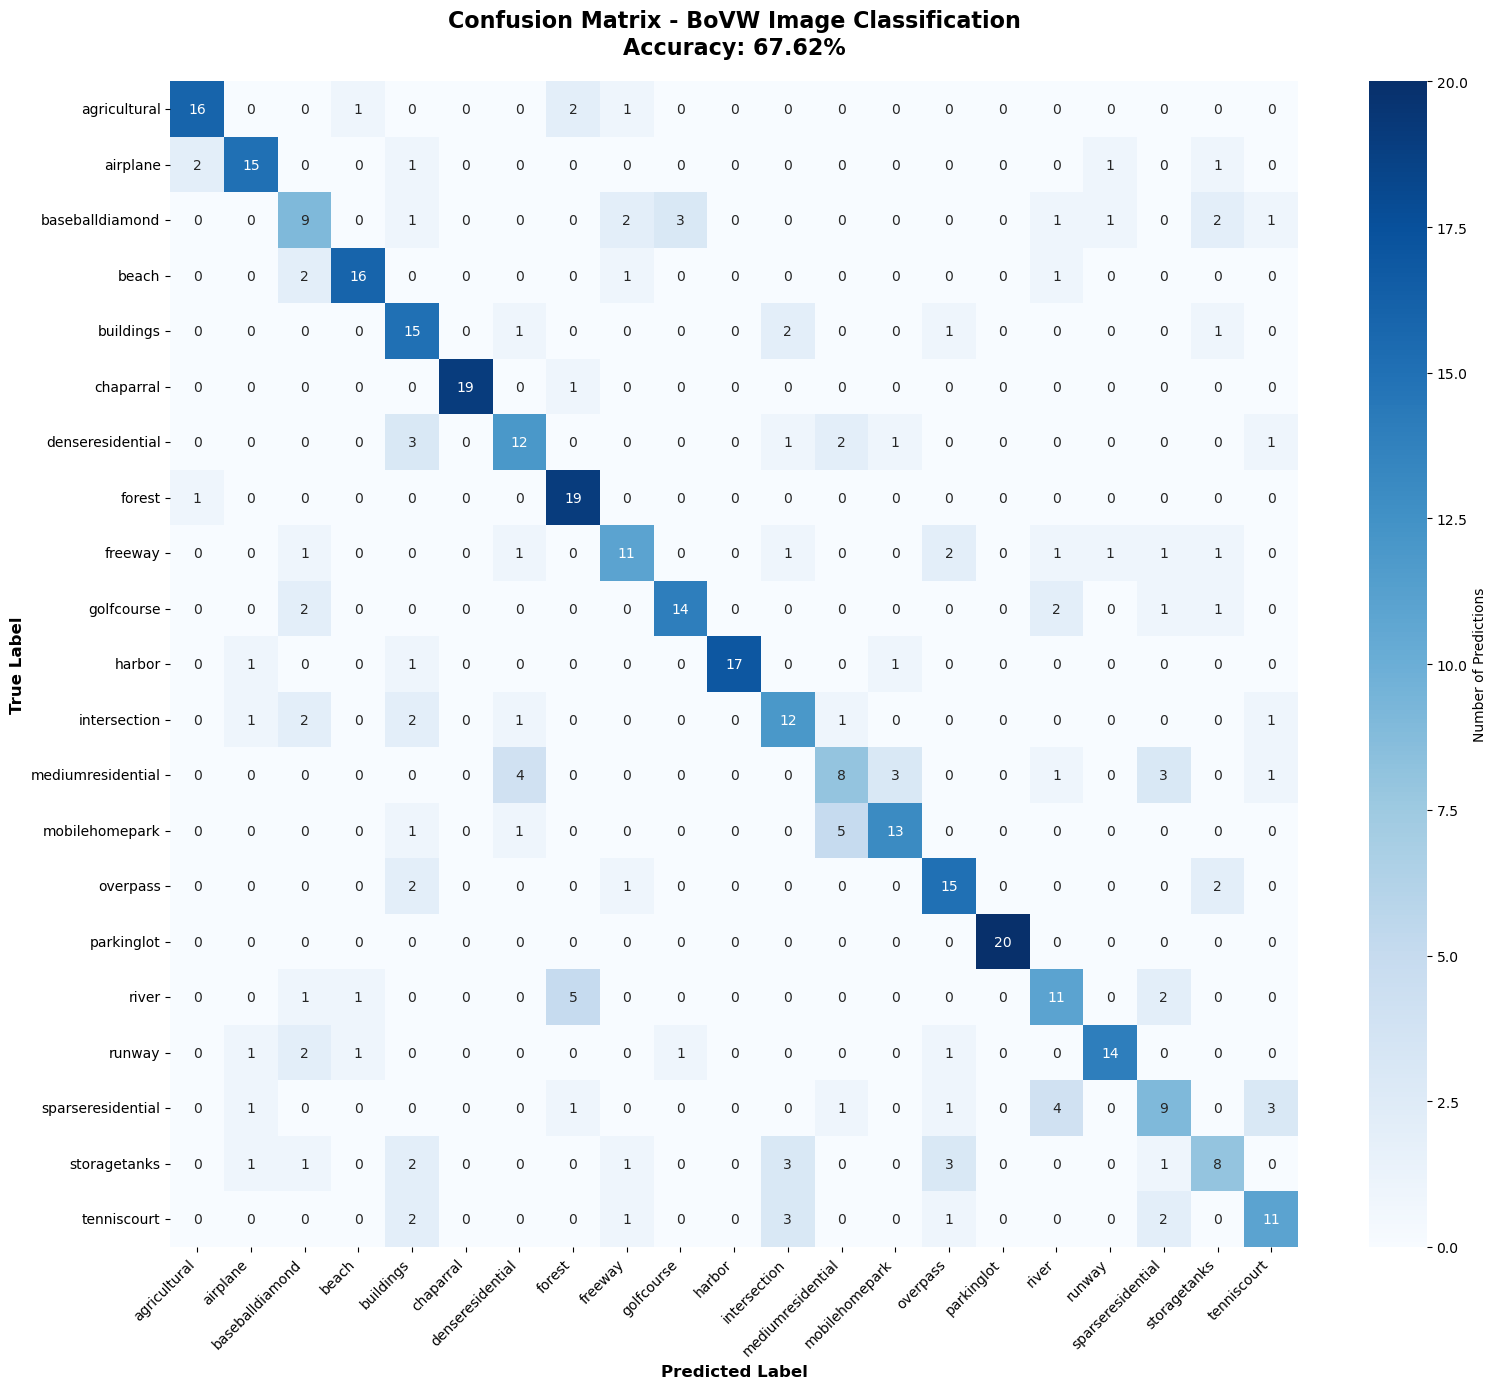


Confusion Matrix:
[[16  0  0  1  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2 15  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0]
 [ 0  0  9  0  1  0  0  0  2  3  0  0  0  0  0  0  1  1  0  2  1]
 [ 0  0  2 16  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0 15  0  1  0  0  0  0  2  0  0  1  0  0  0  0  1  0]
 [ 0  0  0  0  0 19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0 12  0  0  0  0  1  2  1  0  0  0  0  0  0  1]
 [ 1  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  1  0 11  0  0  1  0  0  2  0  1  1  1  1  0]
 [ 0  0  2  0  0  0  0  0  0 14  0  0  0  0  0  0  2  0  1  1  0]
 [ 0  1  0  0  1  0  0  0  0  0 17  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  2  0  2  0  1  0  0  0  0 12  1  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  4  0  0  0  0  0  8  3  0  0  1  0  3  0  1]
 [ 0  0  0  0  1  0  1  0  0  0  0  0  5 13  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  1  0  0  0  0  0 15  0  0  0  

In [13]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=class_names)

# Create figure
plt.figure(figsize=(16, 14))

# Plot confusion matrix
sns.heatmap(
    cm, 
    annot=True,           # Show numbers
    fmt='d',              # Integer format
    cmap='Blues',         # Color scheme
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Number of Predictions'}
)

plt.title(f'Confusion Matrix - BoVW Image Classification\nAccuracy: {accuracy*100:.2f}%', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
print(cm)

## Summary of Results

### Pipeline Parameters:
- **Dataset**: UC Merced Land Use Dataset
- **Train/Test Split**: 80% / 20%
- **Feature Extractor**: SIFT
- **Visual Vocabulary Size (K)**: 100 visual words
- **Normalization**: L2
- **Classifier**: SVM with RBF kernel

### Key Concepts:
1. **SIFT Features**: Local image descriptors invariant to scale and rotation
2. **Visual Words**: Cluster centers from K-means representing common local patterns
3. **Quantization**: Mapping local descriptors to nearest visual word
4. **Histogram**: Frequency distribution of visual words in an image
5. **BoVW**: Each image represented as a histogram of visual word occurrences

### Next Steps for Improvement:
- Experiment with different K values (50, 150, 200)
- Try different normalization methods (L1 vs L2)
- Tune SVM hyperparameters (C, gamma)
- Test other classifiers (Random Forest, Neural Networks)
- Use dense SIFT or other feature extractors (ORB, SURF)